# Learning on a modified Ornstein–Uhlenbeck process

The Ornstein-Uhlenbeck process is an auto-regressive process of order 1, and can be understood as a random walk that can be used for modelling timeseries in applicative fields such as physics, biology or finance.
We generate that process and disturb it at times with gaussian noise for demonstrating this component.

In [1]:
def ornstein_uhlenbeck_anomaly(
        t,
        size=1,
        noise_scale=1,
        mean_reverting=1,
        anomaly_freq=1,
        anomaly_duration=.1,
        anomaly_scale=1,
        seed=314,
):
    rng = np.random.RandomState(seed)
    length, = t.shape
    y = np.zeros(length)
    X = np.empty((length, size))
    X[0] = 0
    target = np.zeros(size)
    for i in range(1, length):
        dt = t[i] - t[i - 1]
        target *= np.exp(-dt / anomaly_duration)
        X[i] = rng.normal(
            target + (X[i - 1] - target) * np.exp(-mean_reverting * dt),
            noise_scale * dt ** .5
        )
        if rng.rand() < dt / anomaly_freq:
            y[i] = 1
            target += rng.normal(scale=anomaly_scale, size=size)
    return X, y

<Axes: >

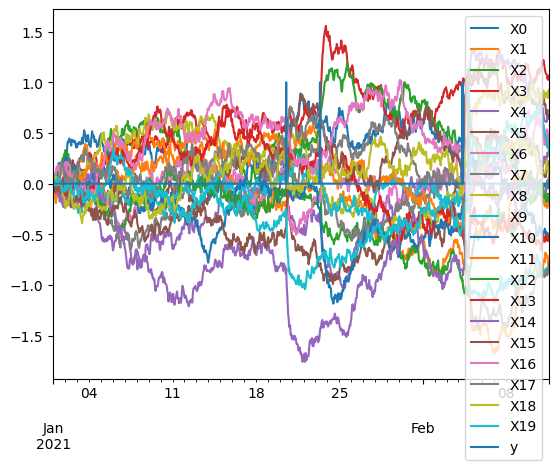

In [2]:
import numpy as np
import pandas as pd

t = np.arange(1000)
t = t / t.shape[0]
pre_X, pre_y = ornstein_uhlenbeck_anomaly(
    t,
    size=20,
    noise_scale=1,
    mean_reverting=3,
    anomaly_freq=.1,
    anomaly_duration=0.005,
    anomaly_scale=40,
)
t = pd.to_datetime('2021-01-01') + pd.Timedelta(1, 'h') * np.arange(t.shape[0])
X = pd.DataFrame(pre_X, index=t, columns=[f'X{i}' for i in range(pre_X.shape[1])])
y = pd.DataFrame(pre_y[:, None], index=t, columns=['y'])

data = (X, y)
pd.concat(data, axis=1).plot()

# Topological embedding of a multiple time series


## The persistence diagram transform

A major tool from the Topological Data Analysis (TDA) field is the persistence diagram, that summarizes information in the form of a set of points in $\mathbf{R}^2$.

For instance if we try to extract topological information on the entire multiple timeseries `X`:

[03-07 15:27:11] {/home/martin.royer/SVN/tdaad/tdaad/twe_logger.py:104} INFO - Logger: name: twe_logger, handlers: [<StreamHandler stdout (DEBUG)>]
[03-07 15:27:11] {/home/martin.royer/SVN/tdaad/tdaad/twe_logger.py:104} INFO - Logger: name: twe_logger, handlers: [<StreamHandler stdout (DEBUG)>]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

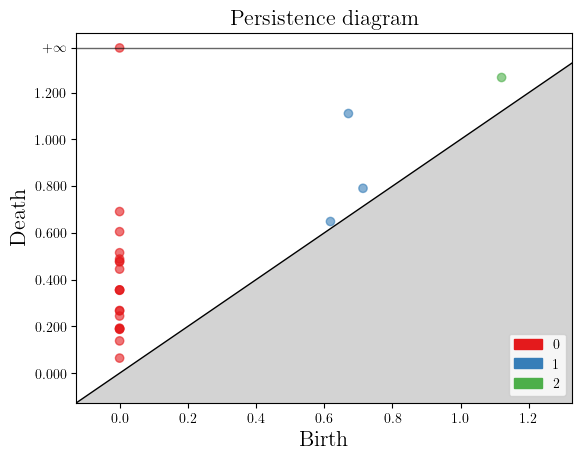

In [3]:
from tdaad.topological_embedding import PersistenceDiagramTransformer

from gudhi import plot_persistence_diagram
global_pdiagram = PersistenceDiagramTransformer(reformatting=False).fit_transform(X)
plot_persistence_diagram(global_pdiagram[0])

## The sliding window algorithm

In order to capture local information and detect potential anomalies, we cut the multiple timeseries in regular chunks or _windows_, and apply the Persistence Diagram Transform on each window. Therefore we transform the original time series into a persistence diagram time series, for instance if we cut it in three parts:

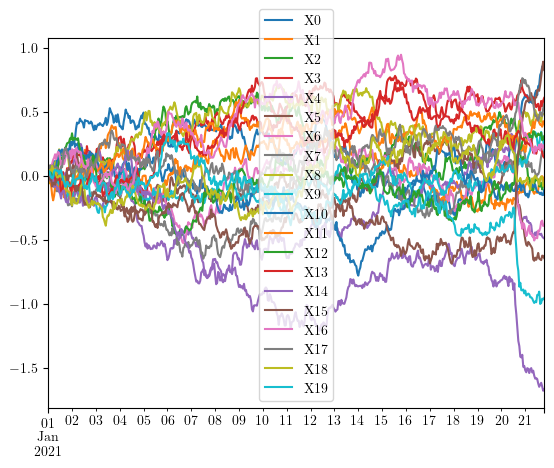

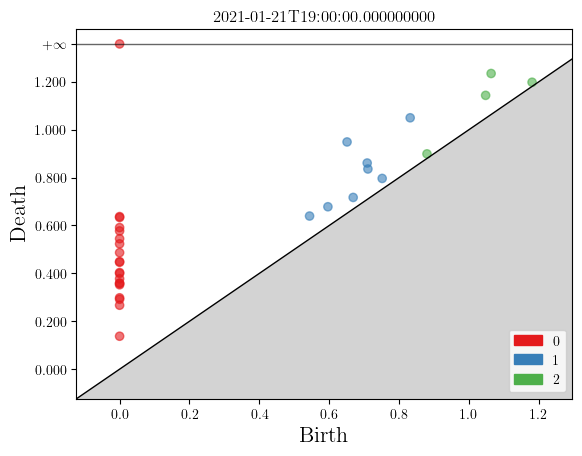

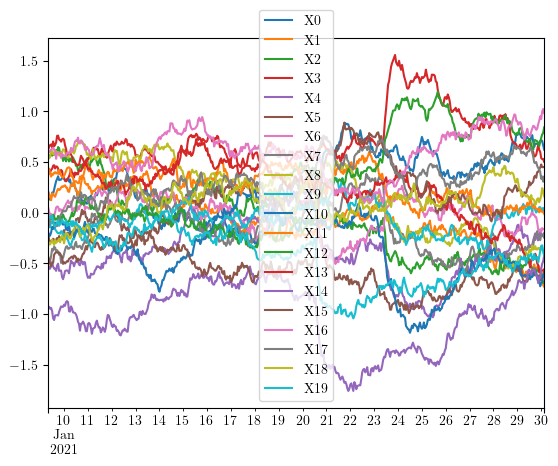

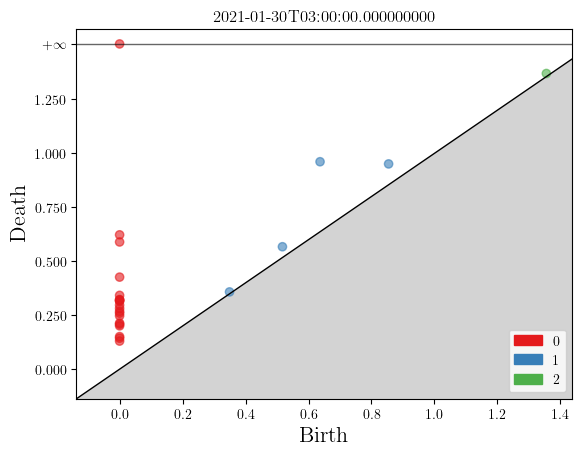

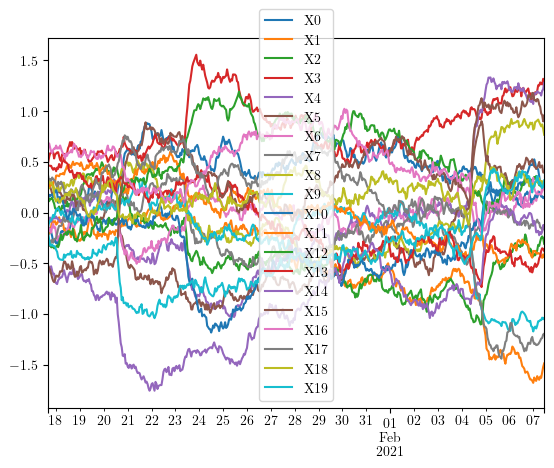

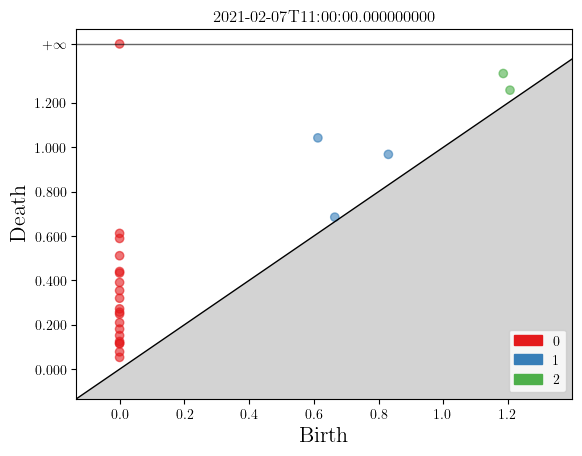

In [4]:
swv = np.lib.stride_tricks.sliding_window_view(X.index, X.shape[0]//2)[::200, :]

for window in swv:
    pdiagram = PersistenceDiagramTransformer(reformatting=False).fit_transform(X.loc[window])
    X.loc[window].plot()
    ax = plot_persistence_diagram(pdiagram[0])
    ax.set_title(str(window[-1]))

## Vectorizing topological information

These persistence diagrams carry the information associated to a homological dimension, but the number of these points cannot be predicted generally, and therefore persistence diagrams need to be vectorized in order to integrate a classical machine learning pipeline. This is done using the `Atol` and `Archipelago` tools from the Gudhi library, and the `PersistenceDiagramTransformer` is integrated into a larger pipeline making use of these tools.

Selecting a number of encoding points by dimension, `n_centers_by_dim`, this results in a _representation method_ we call `TopologicalEmbedding`.


Now we apply the procedure from before with the sliding window algorithm. So instead of a single embedding vector, we get a vector for each window in the timeseries `X`:

In [5]:
from tdaad.topological_embedding import TopologicalEmbedding

embedder = TopologicalEmbedding(window_size=50, n_centers_by_dim=2).fit(X)
embedding = embedder.transform(X)
embedding

,Atol0__feat-1,Atol0__feat-2,Atol1__feat-1,Atol1__feat-2,Atol2__feat-1,Atol2__feat-2
2021-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2021-02-11 11:00:00,8.259610,7.100526,0.267054,2.686448,0.041066,0.303877
2021-02-11 12:00:00,8.314042,6.872867,0.453548,2.640181,0.082132,0.607754
2021-02-11 13:00:00,8.368473,6.645208,0.640042,2.593914,0.123198,0.911631
2021-02-11 14:00:00,8.422904,6.417550,0.826536,2.547647,0.164264,1.215508


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

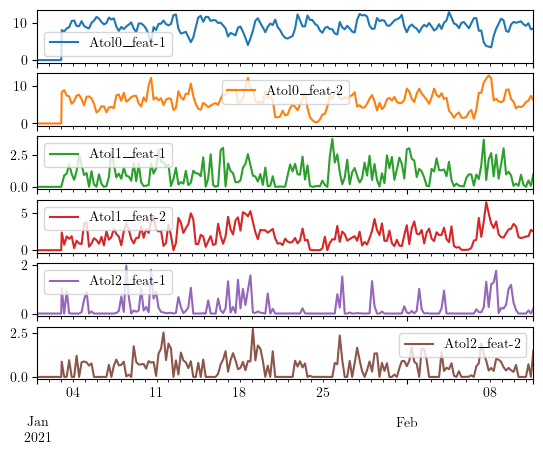

In [6]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

embedding.loc[X.index[0], :] = np.nan
embedding.plot(subplots=True)

# Anomaly Detection based on topological features

What is left is to analyze those topological features for detecting anomaly. We use a procedure from `scikit-learn` called `EllipticEnvelope` based on a robust covariance estimation procedure, that estimates the topological mean and covariance of the vectors and use these to produce the associated mahalanobis distance. Once this distance is defined, an anomaly score is simply derived from it.

In [7]:
from tdaad.anomaly_detectors import TopologicalAnomalyDetector

detector = TopologicalAnomalyDetector(window_size=50, n_centers_by_dim=2, tda_max_dim=1).fit(X)
anomaly_score = detector.score_samples(X)
anomaly_score

,score-exhaustive
2021-01-01 00:00:00,0.000000
2021-01-01 01:00:00,0.000000
2021-01-01 02:00:00,0.000000
2021-01-01 03:00:00,0.000000
2021-01-01 04:00:00,0.000000
...,...
2021-02-11 11:00:00,-2.223949
2021-02-11 12:00:00,-2.123167
2021-02-11 13:00:00,-2.022384
2021-02-11 14:00:00,-1.921602


array([<Axes: >, <Axes: >], dtype=object)

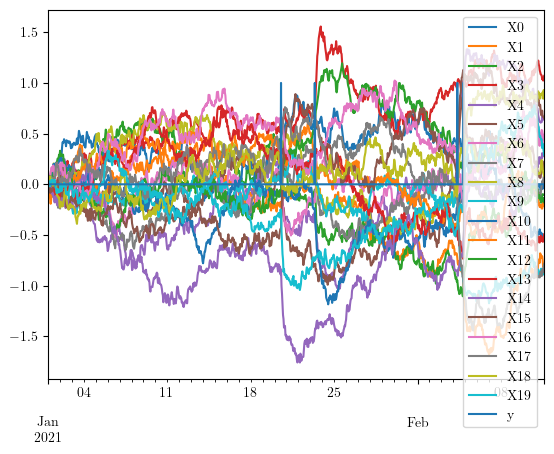

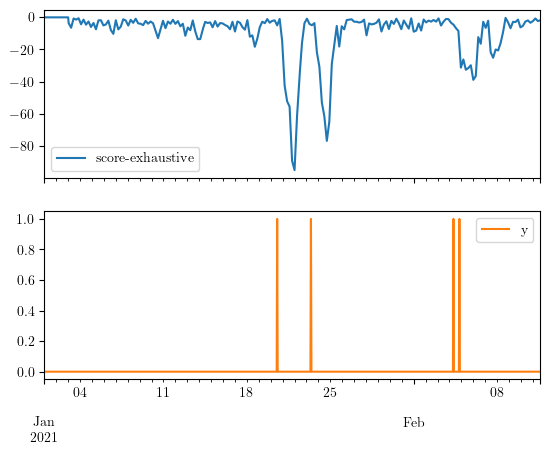

In [8]:
pd.concat(data, axis=1).plot()
pd.concat([anomaly_score, y], axis=1).plot(subplots=True)